In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import os
import time
import math
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf # You know what tensorflow is used for
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, SeparableConv2D, AveragePooling2D, Dense, Add
from tensorflow.keras.models import Model
print(tf.__version__)

from pathlib import Path
import PIL
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2.17.1


In [3]:
# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# Make sure TensorFlow uses the GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Num GPUs Available:  0


In [4]:
#Function to convert labels into my convnet labels
conv_output = 20 # A 20x20x5 grid output from the convnet
img_size = 224
i = 2
np.set_printoptions(linewidth=np.inf, precision=10, threshold=np.inf)
def set_labels(conv_output):
    global i
    directory_train = Path("../input/face-detection-dataset/labels/train/")
    directory_val = Path("../input/face-detection-dataset/labels/val/")
    directory_new_train = Path('./train')
    directory_new_val = Path('./val')

    # Check if the directory exists, and if not, create it
    directory_new_train.mkdir(exist_ok=True)
    directory_new_val.mkdir(exist_ok=True)
    
    #First train directory
    for file_path in directory_train.glob('*.txt'):
        with file_path.open('r') as file:
            content = file.read()
            content = content.split('\n')
            content = [s.split(' ') for s in content if s]
            content = [[float(i) for i in element] for element in content]
            placeholder = np.ones((conv_output,conv_output,5))
            for box in content:
                bx = math.floor(box[1] * conv_output)
                by = math.floor(box[2] * conv_output)
                # I know I can do this at once but I like the clarity here
                placeholder[by][bx][0] = 0 #set the confidence of the box containing obect midpoint
                placeholder[by][bx][1:] = box[1:] #set the bounding box coordinates 
            placeholder = placeholder.reshape(-1,)
            placeholder = ' '.join(map(str, placeholder))
            k = directory_new_train / file_path.name.split('/')[-1]
            with k.open('w') as file2:
                file2.write(placeholder)
                
    #Second val directory
    for file_path in directory_val.glob('*.txt'):
        with file_path.open('r') as file:
            content = file.read()
            content = content.split('\n')
            content = [s.split(' ') for s in content if s]
            content = [[float(i) for i in element] for element in content]
            placeholder = np.ones((conv_output,conv_output,5))
        for box in content:
            bx = math.floor(box[1] * conv_output)
            by = math.floor(box[2] * conv_output)
            # I know I can do this at once but I like the clarity here
            placeholder[by][bx][0] = 0 #set the confidence of the box containing obect midpoint
            placeholder[by][bx][1:] = box[1:] #set the bounding box coordinates 
        placeholder = placeholder.reshape(-1,)
        placeholder = ' '.join(map(str, placeholder))
        k = directory_new_val / file_path.name.split('/')[-1]
        with k.open('w') as file2:
            file2.write(placeholder)
a = time.time()
set_labels(conv_output)
b = time.time()
print("It took ",b - a,"seconds to perform the labelling")

It took  234.8183400630951 seconds to perform the labelling


In [ ]:
# k = tf.io.read_file(tf.constant('./train/90cc772eb8d72107.txt'))
# k = tf.strings.split(k, sep=' ')
# k = tf.strings.to_number(k, out_type=tf.float32)
# k = tf.reshape(k, [20,20,5])
# print(k)

In [8]:
conv_output = 20 # A 20x20x5 grid output from the convnet
img_size = 224
i = 2
#The separators for label are important in both functions depending on windows or linux
with tf.device('/GPU:0'):
    def load_image_and_labels(image_path):
        """Loads image and labels from a .txt file."""
        image = tf.io.read_file(image_path)  # Use tf.io for image reading
        image = tf.io.decode_jpeg(image, channels=3) # Decode JPEG (adjust if needed)
        # Check if the image is grayscale and convert if necessary
        if image.shape[-1] == 1: # If it is a gray scale image convert it to RGB
            image = tf.image.grayscale_to_rgb(image)
        image = tf.image.resize(image, (img_size,img_size),preserve_aspect_ratio=True, antialias=True) # Resize images (important for consistent input)
        image = tf.image.resize_with_pad(image, img_size, img_size)
        image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values (0-1)
    
         # Get label path
        #label_path = tf.strings.regex_replace(image_path, 'images', 'labels')
        #label_path = tf.strings.regex_replace(label_path, '\.jpg$', '.txt')
        label_path = tf.strings.regex_replace(image_path, '\.jpg$', '.txt')
        str_const = tf.constant('./train/')
        label = tf.io.read_file(tf.strings.join([str_const, tf.strings.split(label_path, sep='\\')[-1]]))
        label = tf.strings.split(label, sep=' ')
        label = tf.strings.to_number(label, out_type=tf.float32)
        label = tf.reshape(label, [20,20,5])
        
        # # Read label file
        # label = tf.io.read_file(label_path)
        # label = tf.strings.split(label, '\r\n')
    
        # # To filter out empty strings
        # label = tf.strings.regex_replace(label, '^$', '')
        # label = tf.boolean_mask(label, tf.strings.length(label) > 0)
        
        # # Convert label to tensor (assuming YOLO format: class x_center y_center width height)
        # label = tf.strings.strip(label)
        # label = tf.strings.split(label, ' ')
        # label = tf.strings.to_number(label, out_type=tf.float32)
        
        return image, label
    
    def create_dataset(image_dir):
        """Creates a tf.data.Dataset from image and label files."""
        dataset = tf.data.Dataset.list_files(image_dir, shuffle=False)  # Or *.png, etc.
        # image_paths = list(Path(image_dir).glob('*.jpg'))  # Get all image paths
        # image_paths = [str(p) for p in image_paths]
        #dataset = tf.data.Dataset.from_tensor_slices(image_paths)
        dataset = dataset.map(load_image_and_labels,num_parallel_calls=tf.data.AUTOTUNE)  # Parallel processing
        return dataset

    def load_image_and_labels2(image_path):
        """Loads image and labels from a .txt file."""
        image = tf.io.read_file(image_path)  # Use tf.io for image reading
        image = tf.io.decode_jpeg(image, channels=3) # Decode JPEG (adjust if needed)
        # Check if the image is grayscale and convert if necessary
        if image.shape[-1] == 1: # If it is a gray scale image convert it to RGB
            image = tf.image.grayscale_to_rgb(image)
        image = tf.image.resize(image, (img_size,img_size),preserve_aspect_ratio=True, antialias=True) # Resize images (important for consistent input)
        image = tf.image.resize_with_pad(image, img_size, img_size)
        image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values (0-1)
    
         # Get label path
        #label_path = tf.strings.regex_replace(image_path, 'images', 'labels')
        #label_path = tf.strings.regex_replace(label_path, '\.jpg$', '.txt')
        label_path = tf.strings.regex_replace(image_path, '\.jpg$', '.txt')
        str_const = tf.constant('./val/')
        label = tf.io.read_file(tf.strings.join([str_const, tf.strings.split(label_path, sep='\\')[-1]]))
        label = tf.strings.split(label, sep=' ')
        label = tf.strings.to_number(label, out_type=tf.float32)
        label = tf.reshape(label, [20,20,5])
        
        # # Read label file
        # label = tf.io.read_file(label_path)
        # label = tf.strings.split(label, '\r\n')
    
        # # To filter out empty strings
        # label = tf.strings.regex_replace(label, '^$', '')
        # label = tf.boolean_mask(label, tf.strings.length(label) > 0)
        
        # # Convert label to tensor (assuming YOLO format: class x_center y_center width height)
        # label = tf.strings.strip(label)
        # label = tf.strings.split(label, ' ')
        # label = tf.strings.to_number(label, out_type=tf.float32)
        
        return image, label
    
    def create_dataset2(image_dir):
        """Creates a tf.data.Dataset from image and label files."""
        dataset = tf.data.Dataset.list_files(image_dir, shuffle=False)  # Or *.png, etc.
        # image_paths = list(Path(image_dir).glob('*.jpg'))  # Get all image paths
        # image_paths = [str(p) for p in image_paths]
        #dataset = tf.data.Dataset.from_tensor_slices(image_paths)
        dataset = dataset.map(load_image_and_labels2,num_parallel_calls=tf.data.AUTOTUNE)  # Parallel processing
        return dataset
# Example usage:

    image_directory = '../input/face-detection-dataset/images/train/*.jpg'
    val_image_directory = '../input/face-detection-dataset/images/val/*.jpg'
    dataset = create_dataset(image_directory)
    val_dataset = create_dataset2(val_image_directory)
    # for image, boxes in dataset.take(5):
    #     print("Image shape:", image.shape)
    #     tf.print("Boxes shape:", boxes)
                
    # Batching and other dataset operations:
    dataset = dataset.batch(32)
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    val_dataset = val_dataset.batch(32)
    val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)


In [11]:
for image, label in dataset.take(1):
    print("Image shape:", image.shape)
    print("Boxes shape:", label.shape)

for image, label in val_dataset.take(1):
    print("Image shape:", image.shape)
    print("Boxes shape:", label.shape)

Image shape: (32, 224, 224, 3)
Boxes shape: (32, 20, 20, 5)
Image shape: (32, 224, 224, 3)
Boxes shape: (32, 20, 20, 5)


In [1]:
import os
print(os.name)

nt


In [13]:

image_directory = Path('../input/face-detection-dataset/images/train')
print(image_directory)
image_count = len(list(image_directory.glob('*.jpg')))
print(image_count)

..\input\face-detection-dataset\images\train
13386


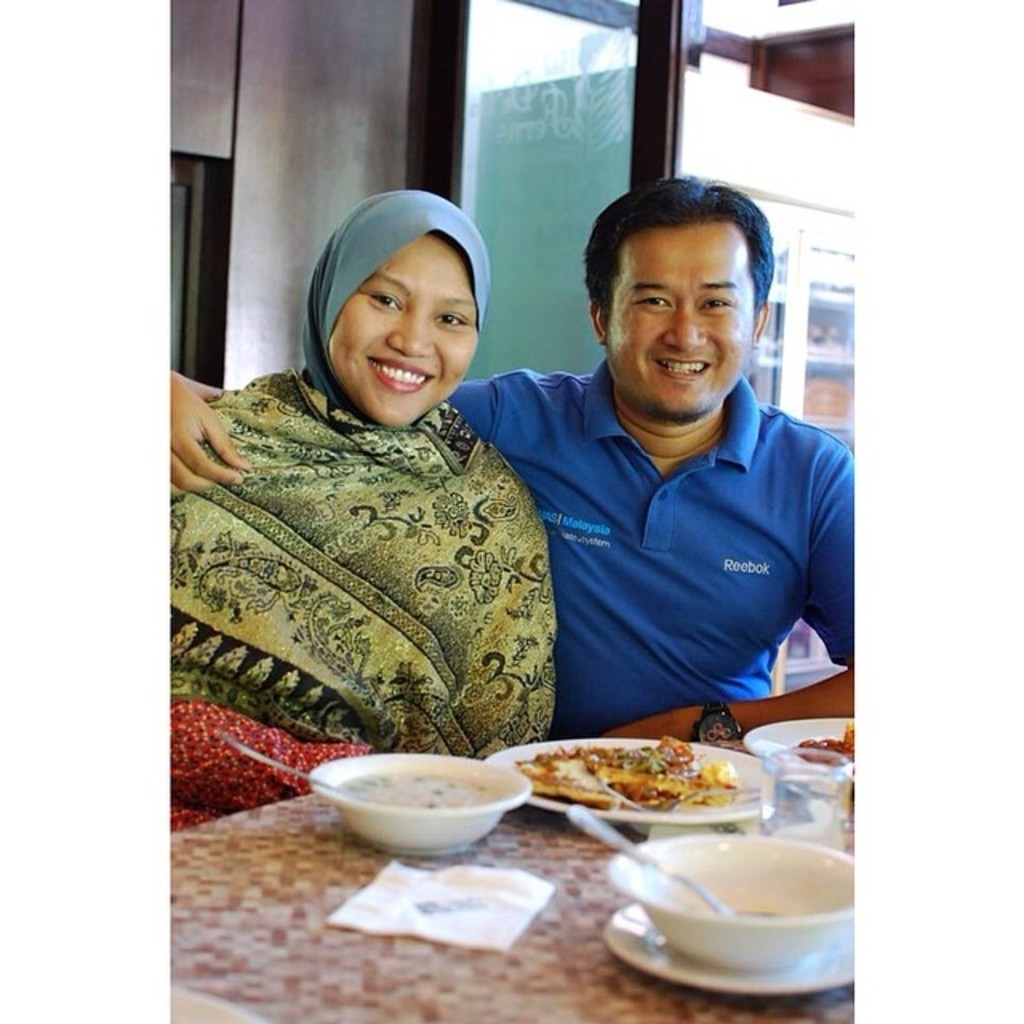

In [14]:
images = image_directory.glob('*.jpg')
PIL.Image.open(str(list(images)[0]))

In [ ]:
list_ds = tf.data.Dataset.list_files('./face_dataset/images/train/*.jpg', shuffle=False)
for f in list_ds.take(5):
  print(f.numpy())

In [15]:
with tf.device('/GPU:0'):  
    inputs = tf.keras.Input(shape=(img_size,img_size,3))
    x = Conv2D(filters=32, kernel_size=3, padding='same')(inputs) #outputs 224x224x32
    x = BatchNormalization()(x)
    x = ReLU(negative_slope=0.01)(x)
    '''START OF BOTTLENECK'''
    input_to_bottleneck = x
    x = Conv2D(6 * 32, 1)(x) #outputs 224x224x192 expansion
    x = SeparableConv2D(32, 3,padding='same')(x) #outputs 224x224x32 depthwise separable
    x = Add()([input_to_bottleneck, x])
    '''END OF BOTTLENECK'''
    x = AveragePooling2D(2,strides=2)(x) #Outputs 112x112x32
    '''START OF BOTTLENECK'''
    input_to_bottleneck = x
    x = Conv2D(6 * 32 * 3, 1)(x) #outputs 112x112x576 expansion
    x = SeparableConv2D(32, 3,padding='same')(x) #outputs 112x112x32 depthwise separable
    x = BatchNormalization()(x)
    x = ReLU(negative_slope=0.01)(x)
    x = Add()([input_to_bottleneck, x])
    '''END OF BOTTLENECK'''
    x = AveragePooling2D(2,strides=2)(x) #Outputs 56x56x32
    '''START OF BOTTLENECK'''
    input_to_bottleneck = x
    x = Conv2D(6 * 32 * 3 * 2, 1)(x) #outputs 56x56x1152 expansion
    x = SeparableConv2D(32, 3,padding='same')(x) #outputs 56x56x32 depthwise separable
    x = BatchNormalization()(x)
    x = ReLU(negative_slope=0.01)(x)
    x = Add()([input_to_bottleneck, x])
    '''END OF BOTTLENECK'''
    x = AveragePooling2D(2,strides=2)(x) #Outputs 28x28x32
    '''START OF BOTTLENECK'''
    input_to_bottleneck = x
    x = Conv2D(6 * 32 * 3, 1)(x) #outputs 28x28x576 expansion
    x = SeparableConv2D(32, 3,padding='same')(x) #outputs 28x28x32 depthwise separable
    x = BatchNormalization()(x)
    x = ReLU(negative_slope=0.01)(x)
    x = Add()([input_to_bottleneck, x])
    '''END OF BOTTLENECK'''
    x = SeparableConv2D(16, 5,padding='valid')(x) #outputs 24x24x16 depthwise separable
    outputs = SeparableConv2D(5, 5,padding='valid')(x) #outputs 20x20x5 depthwise separable
    
    model = tf.keras.Model(inputs=inputs,outputs=outputs)

In [5]:
# def decoder(labels, batch_shape):
#     placeholder = tf.ones([batch_shape,20,20,5])
#     for example in range(len(labels)):
#         for box in range(len(example)):
#             bx = math.floor(labels[example][box][1] * 224)
#             by = math.floor(labels[example][box][2] * 224)
#             placeholder[example][by][bx][0] = 0 #set the confidence of the box containing obect midpoint
#             placeholder[example][by][bx][1:] = box[1:] #set the bounding box coordinates
#     return placeholder
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
mse = tf.keras.losses.MeanSquaredError()
import keras
@keras.saving.register_keras_serializable()
def customLoss(y_true,y_pred):
    """
    Custom loss for Yolo detection. Speciliased for face detection dataset
    """
    loss_bounding_box = 5
    loss_noobj = 0.5

    #Decode the tensors
    #new_y_true = decoder(y_true, y_true.shape[0])
    true_confidence = y_true[...,0]
    true_coordinates = y_true[...,1:]
    pred_confidence = y_pred[...,0]
    pred_coordinates = y_pred[...,1:]

    #mask for obj present and noobj present in box
    mask_obj = true_confidence == 0
    mask_noobj = true_confidence == 1

    # Confidence loss
    obj_loss = bce(true_confidence[mask_obj], pred_confidence[mask_obj])
    no_obj_loss = bce(true_confidence[mask_noobj], pred_confidence[mask_noobj])
    confidence_loss = obj_loss + (loss_noobj * no_obj_loss)

    #bounding box loss
    box_loss = mse(true_coordinates[mask_obj], pred_coordinates[mask_obj])
    box_loss *= loss_bounding_box

    #total yolo loss
    total_loss = confidence_loss + box_loss

    return total_loss
    

In [17]:
#tf.config.run_functions_eagerly(False)
model.compile(loss=customLoss,optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

In [ ]:
model.fit(dataset, validation_data=val_dataset, epochs=1)

In [18]:
loaded_model = tf.keras.models.load_model('yolo_face.keras', custom_objects={'customLoss': customLoss})

In [28]:
loaded_model.fit(dataset, validation_data=val_dataset, epochs=30)

Epoch 1/30
419/419 ━━━━━━━━━━━━━━━━━━━━ 179s 284ms/step - loss: 0.5556 - val_loss: 0.6661
Epoch 2/30


KeyboardInterrupt: 

In [27]:
#Fine tuning
loaded_model.compile(loss=customLoss, optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, weight_decay=1e-4))

In [29]:
loaded_model.save('final_yolo.keras')

In [ ]:
"""PART FOR FILTERING THE OUTPUT OF THE CONVNET"""
#Pick a random image
#resize the image
#run prediction
#clean the output

In [6]:
latest_model = tf.keras.models.load_model('final_yolo.keras', custom_objects={'customLoss': customLoss})

In [13]:
for image,label in val_dataset.take(1):
    rand_image = image
    print(latest_model.predict(rand_image).shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 59s 59s/step
(32, 20, 20, 5)
